<h1> Singular Curves </h1>
Although , EC provide a high level of security , there are some weak curves where the ECDLP become much easier to break, singular curves one of them .it's enough to check the singularity of the curve , then we use some isomorphismes to map the points into $\mathbb{Z}_{p}$
we call a  curve  singular when its determinant $\equiv 0 [p]$ .

In [1]:
from Crypto.Util.number import *
import matplotlib.pyplot as plt
import numpy as np
from sage.all import *


<h2> Nodes </h2>
A Node is a curve with the equation :$$ (E): y^{2} = x^{2} * (x +k) , with \quad k \in \mathbb{Z} $$.
And we notice that the equation $ y = 0 $ has a double solution k, and that's the point of weaknes of nodes because it's trivial that the determinant = 0 in this case .


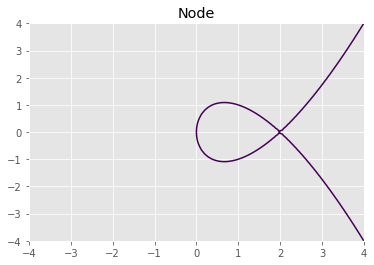

In [3]:
y, x = np.ogrid[-4:4:100j, -4:4:100j]
plt.contour(x.ravel(), y.ravel(),pow(y, 2) - x * pow(x-2 , 2), [0])
plt.title("Node")
plt.style.use("ggplot")
plt.show()

<h2>The Math behind the attack</h2>
Our aim is to map the curve points to $Z_{p}$, let us observe the singularity again : <br>
$$ (E): y^{2} = x^{2} * (x+k), \implies y = \sqrt{x+k} * \left|x \right|  $$
the point (0,0) represents the singularity 

and $$ \lim_{x \to 0} \dfrac{dy}{dx} = \pm\sqrt{k} $$, so the tangent will be $$ y = \pm\sqrt{k}x $$
<h3> the isomorphisme </h3>
Let  $$ \phi : (E) \to (\mathbb{Z}_{p},*) ,  \\
x \to \dfrac{y+\sqrt{k}x}{y-\sqrt{k}x} $$ , we can prove that $\phi$ is a valide isomorphisme easily .<br>

Note : in this Notebook we will process the case where k is a complete square.
so we will chose a prime p in the form 4m+3 to make the quadratic residus problem  much easier.
<h2>The Code </h2>

In [4]:
while True:
    q = getPrime(96)
    p = 4*q +3
    if isPrime(p) :
        break
p
    


181870022725998048457266960991

In [5]:
from collections import namedtuple
from Crypto.Util.number import inverse

Point = namedtuple("Point", "x y")

O = Point(0,0)

class EllipticCurve(object):
        def __init__(self,prime,a,b,c):
            self.p = prime
            self.a = a
            self.b = b
            self.c = c
            
        


        def check_point(self,P):
            if P == O:
                return True
            else:
                return ((pow(P.y,2,self.p) - (P.x**3 + self.a * P.x**2 + self.b*P.x + self.c)) % self.p == 0 )and 0 <= int(P.x) < self.p and 0 <= int(P.y) < self.p


        def point_inverse(self,P):
            if P == O:
                return P
            return Point(P.x, -P.y % self.p)


        def point_addition(self,P, Q):
            if P == O:
                return Q
            elif Q == O:
                return P
            elif Q == self.point_inverse(P):
                return O
            else:
                if P == Q:
                    lam = (3*P.x**2 + self.a*2*P.x + self.b) * inverse(int((2*P.y)), self.p)
                    lam %= self.p
                else:
                    lam = (Q.y - P.y) * inverse(int((Q.x - P.x)), self.p)
                    lam %= self.p
            Rx = (lam**2 - self.a - P.x - Q.x) % self.p
            m = (P.y - lam * P.x) % self.p
            Ry = -(lam*Rx + m) % self.p
            R = Point(Rx, Ry)
            #assert check_point(R)
            return R


        def double_and_add(self,n, P):
            Q = P
            R = O
            while n > 0:
                if n % 2 == 1:
                    R = self.point_addition(R, Q)
                Q = self.point_addition(Q, Q)
                n = n // 2
            #assert check_point(R)
            return R
        def __str__(self):
            return f"Elliptic Cuvre Over the field {self.p} defined as : x^3 + {self.a} x^2 + {self.b} x + {self.c} "


In [8]:
#define the node
k = 4
P.<x> = PolynomialRing(GF(p))
f = x * (x - k)**2

f

x^3 + 181870022725998048457266960983*x^2 + 16*x

In [9]:
a,b,c = f[2],f[1],f[0]
q = (p-3)//4
E = EllipticCurve(p ,a,b,c)
E.__str__()

'Elliptic Cuvre Over the field 181870022725998048457266960991 defined as : x^3 + 181870022725998048457266960983 x^2 + 16 x + 0 '

<h3> Test </h3>

In [10]:

G=Point(2, pow(f(2),q+1 , p ))
#the generator
G = E.double_and_add(8,G)

E.check_point(G)


True

In [11]:

d = b'secret'  #the private key
d = bytes_to_long(d)
assert d < p-1
#the public key
Q = E.double_and_add(d,G)
E.check_point(Q)

True

In [12]:
def isomorph(P):
    return ((int(P.y) + 2 * int(P.x)) * inverse(int(P.y)  - 2 * int(P.x),p) )  % p



In [13]:
#first we have to shift f and its point to make it in the form y^2 = x^2 (x+k)
f_shift = f.subs(x = x+k)
f_shift

x^3 + 4*x^2

In [14]:
G_shift= Point((G.x -k) % p , G.y)
Q_shift= Point((Q.x - k) % p, Q.y)


q = Mod(isomorph(Q_shift),p)
g = Mod(isomorph(G_shift),p)


d_ = discrete_log(q,g)
print(long_to_bytes(d_))

b'secret'


<h2>Cusps</h2>
A cusp is a curve with the equation : $$ y^{2} = x^{3}  \quad with \quad k  \in \mathbb{Z} $$  
And in this case the equation $ y = 0 $ has triple solution k, and that's represent the point of weaknes of cups because it's trivial that the determinant = 0 in this case .

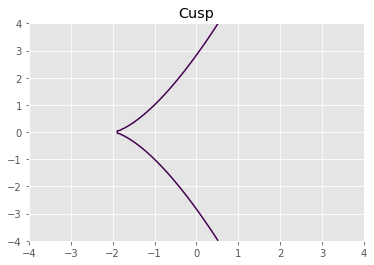

In [7]:
y, x = np.ogrid[-4:4:100j, -4:4:100j]
plt.contour(x.ravel(), y.ravel(),pow(y, 2) - pow(x+2 , 3), [0])
plt.title("Cusp")
plt.style.use("ggplot")
plt.show()

<h2>The Math behind the attack</h2>
Our aim is to map the curve points to $\mathbb{Z}_{p}$, let us observe the singularity again : <br>
$$ (E): y^{2} = x^{3}, \implies y = x^{\dfrac{3}{2}} $$
the point (k,0) represents the singularity 

and $$ \lim_{x \to 0} \dfrac{dy}{dx} = 0 $$, so the tangent will be $$ y = 0 $$
<h3> the isomorphisme </h3>
Let $$ \phi : (E) \to  (\mathbb{Z}_{p},+)  ,  \\
x \to \dfrac{x}{y} $$ , we can prove that $\phi$ is a valide isomorphisme (proof for the reader :p).<br>

<h2>The Code </h2>

In [48]:
P.<x> = PolynomialRing(GF(p))
k = 4
f = (x-k)**3
f

x^3 + 353852509520510184915219022686735811213937867875*x^2 + 48*x + 353852509520510184915219022686735811213937867823

In [49]:
a,b,c = f[2],f[1],f[0]
q = (p-3)//4
E = EllipticCurve(p ,a,b,c)
E.__str__()

'Elliptic Cuvre Over the field 353852509520510184915219022686735811213937867887 defined as : x^3 + 353852509520510184915219022686735811213937867875 x^2 + 48 x + 353852509520510184915219022686735811213937867823 '

In [50]:
G=Point(6, pow(f(6),q+1 , p ))
#the generator
G = E.double_and_add(8,G)

E.check_point(G)
G

Point(x=187984145682771035736210105802328399707404492319, y=172176594459480693014940548551049945767599842622)

In [51]:
d = b'secret'  #the private key
d = bytes_to_long(d)
assert d < p-1
#the public key
Q = E.double_and_add(d,G)
Q

Point(x=335721366305372026687030795969964735023640367208, y=7083234262175643884855506738787152959931750551)

In [52]:
def isomorph(P):
    assert P!=Point(0,0)
    return (int(P.x) * inverse(int(P.y),p) ) %p

In [53]:
f.roots()

[(4, 3)]

In [57]:
#first we have to shift f and its point to make it in the form y^2 = x^3
f_shift = f.subs(x = x+k)
f_shift

x^3

In [55]:

G_shift= Point((G.x -k ) % p , G.y)
Q_shift= Point((Q.x - k) % p, Q.y)


q = isomorph(Q_shift)
g = isomorph(G_shift)


d_ = (inverse(g,p)* q)  % p
print(long_to_bytes(d_))

b'secret'
